## Pre-Processing and Training Data

In [1]:
#Importing all the libraries I believe I will be using
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from library.sb_utils import save_file

In [2]:
meta_df = pd.read_csv('SourceFiles/numerical_data.csv')

In [3]:
#as we can see, there are only numeric fields left in the Dataframe, netiher are null values left
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6726 entries, 0 to 6725
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   metastasis            6726 non-null   int64
 1   tneg                  6726 non-null   int64
 2   invasive              6726 non-null   int64
 3   breast_chest_radi     6726 non-null   int64
 4   nodal_radi            6726 non-null   int64
 5   chemo                 6726 non-null   int64
 6   antihormone           6726 non-null   int64
 7   her2_inhib            6726 non-null   int64
 8   neo                   6726 non-null   int64
 9   er                    6726 non-null   int64
 10  pr                    6726 non-null   int64
 11  p53                   6726 non-null   int64
 12  her2                  6726 non-null   int64
 13  node_status           6726 non-null   int64
 14  age                   6726 non-null   int64
 15  menopause             6726 non-null   int64
 16  node_p

In [4]:
#Counts of null values
na_df=pd.DataFrame(meta_df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount


In [5]:
#counts of response variable values
print(meta_df.shape)
meta_df.metastasis.value_counts()

(6726, 29)


0    6193
1     533
Name: metastasis, dtype: int64

From our data (6726 records), 92% are metastasis free, while 8% presented metastasis

After dropping the duplicated records, we got 88% of metastasis free and 12% of metastazed patients

### Split the data into test and train subsamples

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from pprint import pprint

y = meta_df.metastasis
X = meta_df.drop('metastasis', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [7]:
y0 = meta_df[meta_df['metastasis']==0].metastasis.values
X0 = meta_df[meta_df['metastasis']==0].drop('metastasis', axis=1).values

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=.2, random_state=1)

y1 = meta_df[meta_df['metastasis']==1].metastasis.values
X1 = meta_df[meta_df['metastasis']==1].drop('metastasis', axis=1).values

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=.2, random_state=1)

X_train = np.concatenate((X0_train, X1_train))
X_test = np.concatenate((X0_test, X1_test))
y_train = np.concatenate((y0_train, y1_train))
y_test = np.concatenate((y0_test, y1_test))

#### Building the Logistic Regression model with default parameters

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

# Compute and print the confusion matrix and classification report
pprint(logreg.get_params())
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Logistic Regression Accuracy Score: {}".format(accuracy_score(y_test, y_pred)))

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}
[[1235    4]
 [  98    9]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1239
           1       0.69      0.08      0.15       107

    accuracy                           0.92      1346
   macro avg       0.81      0.54      0.56      1346
weighted avg       0.91      0.92      0.90      1346

Logistic Regression Accuracy Score: 0.924219910846954


C:\Users\Miguel\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


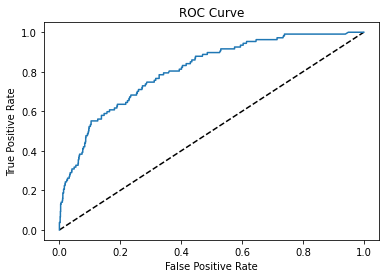

In [9]:
from sklearn.metrics import roc_curve
y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

#### Building the Random Forest model with default parameters

In [10]:
#scale the data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)
#Random Forest Classifier
clf = RandomForestClassifier(random_state = 1)
#fit the model
model_res = clf.fit(X_train_scaled, y_train)
#Predict on test data
y_pred = model_res.predict(X_test_scaled)
#Obtain the predition probabilities
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
#Get the accuracy scores
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

In [11]:
#Print results and default parameters
print("Random Forest Accuracy Score: {}".format(accuracy_score(y_test, y_pred)))
print('Random Forest: f1-score=%.3f' % (f1))
print('Parameters currently in use:\n')
pprint(clf.get_params())
print("Classification report")
print(classification_report(y_test, y_pred))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

Random Forest Accuracy Score: 0.9205052005943536
Random Forest: f1-score=0.899
Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
Classification report
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1239
           1       0.50      0.14      0.22       107

    accuracy                           0.92      1346
   macro avg       0.72      0.56      0.59      1346
weighted avg       0.90      0.92      0.90      1346

Confusion Matrix
[[1224   15]
 [  92   15]]


Since F1-score for random forest for class 1 is better in the default model, I will tune random forest parameters.

#### Tunning the hiperparameters of the model

In [12]:
random_grid = {}

In [13]:
#I am chossing cv=10 because, without duplicates, the amount of metastazed patients are 12% and 88% are metastazed free 
#This way, I ensure there is always representation for metastazed patients.
def validate(param_name, param_range, cv=5):
    train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train, 
                                param_name = param_name, 
                                param_range = param_range, cv = cv)
    return train_scoreNum, test_scoreNum

In [14]:
def plot_param(train_scoreNum, test_scoreNum):
    train_scoreNum = train_scoreNum * 100
    test_scoreNum = test_scoreNum * 100
    train_scores_mean = np.mean(train_scoreNum, axis=1)
    train_scores_std = np.std(train_scoreNum, axis=1)
    test_scores_mean = np.mean(test_scoreNum, axis=1)
    test_scores_std = np.std(test_scoreNum, axis=1)

    plt.title("Validation Curve with RandomForestClassifier")
    plt.xlabel(param_name)
    plt.ylabel("Accuracy Score %")
    plt.ylim(test_scoreNum.min(), train_scoreNum.max())
    lw = 1
    plt.semilogx(param_range, train_scores_mean, label="Training score", color="darkorange")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange")
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="navy")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy")
    plt.legend(loc="best")
    plt.rcParams["figure.figsize"] = (20,5)
    plt.grid(axis='both')
    plt.show()

In [15]:
def print_scores(scores, range):
    #print("     cv=1       cv=2       cv=3       cv=4       cv=5")
    for row in zip(scores, range):
        print(row[1], row[0].mean())

##### class_weight

In [16]:
param_name = 'class_weight'
weights = np.linspace(0.04, 0.96, 24)
param_range = [{0: x, 1: 1.0-x} for x in weights]

train_scoreNum, test_scoreNum = validate(param_name, param_range)
print("train_scoreNum")
print_scores(train_scoreNum, param_range)
print("test_scoreNum")
print_scores(test_scoreNum, param_range)

train_scoreNum
{0: 0.04, 1: 0.96} 0.9730018587360595
{0: 0.07999999999999999, 1: 0.92} 0.9803438661710038
{0: 0.12, 1: 0.88} 0.9828066914498141
{0: 0.15999999999999998, 1: 0.8400000000000001} 0.9834107806691451
{0: 0.19999999999999998, 1: 0.8} 0.9844330855018587
{0: 0.23999999999999996, 1: 0.76} 0.9847583643122677
{0: 0.27999999999999997, 1: 0.72} 0.9851765799256504
{0: 0.31999999999999995, 1: 0.68} 0.9851301115241636
{0: 0.35999999999999993, 1: 0.6400000000000001} 0.9852230483271376
{0: 0.3999999999999999, 1: 0.6000000000000001} 0.9852230483271376
{0: 0.4399999999999999, 1: 0.56} 0.9852695167286246
{0: 0.4799999999999999, 1: 0.52} 0.9852695167286246
{0: 0.5199999999999999, 1: 0.4800000000000001} 0.9852695167286246
{0: 0.5599999999999999, 1: 0.44000000000000006} 0.9852695167286246
{0: 0.6, 1: 0.4} 0.9852695167286246
{0: 0.6399999999999999, 1: 0.3600000000000001} 0.9852230483271376
{0: 0.6799999999999999, 1: 0.32000000000000006} 0.9852230483271376
{0: 0.72, 1: 0.28} 0.9851301115241636
{

In [17]:
#Adding the parameter to the dictionary
#random_grid['class_weight'] = [{0: 0.04, 1: 0.96}, {0: 0.08, 1: 0.92},{0: 0.12, 1: 0.88},{0: 0.20, 1: 0.80}]
#random_grid['class_weight'] = [{0: 0.04, 1: 0.96}, {0: 0.08, 1: 0.92}]
random_grid['class_weight'] = [{0: 0.08, 1: 0.92}]

##### criterion

In [18]:
param_name = 'criterion'
param_range = ['gini','entropy']

train_scoreNum, test_scoreNum = validate(param_name, param_range)
print("train_scoreNum")
print_scores(train_scoreNum, param_range)
print("test_scoreNum")
print_scores(test_scoreNum, param_range)
#plot_param(train_scoreNum, test_scoreNum)

train_scoreNum
gini 0.9851765799256504
entropy 0.9851765799256504
test_scoreNum
gini 0.9169144981412639
entropy 0.9180297397769517


In [19]:
#Adding the parameter to the dictionary
random_grid['criterion'] = ['entropy']

##### max_depth

train_scoreNum
1 0.9208178438661709
2 0.9208178438661709
3 0.9208178438661709
4 0.9210966542750929
5 0.9229089219330856
6 0.9250929368029741
7 0.9288104089219331
8 0.9343401486988847
9 0.9410315985130111
10 0.9485130111524164
11 0.9563197026022305
12 0.9622676579925651
13 0.9688661710037175
14 0.974721189591078
15 0.9784386617100372
16 0.9812732342007436
17 0.9835966542750929
18 0.9847118959107807
19 0.9850836431226767
20 0.9851765799256504
21 0.9851765799256507
22 0.9852230483271376
23 0.9852695167286246
24 0.9852230483271377
25 0.9852230483271377
26 0.9852230483271376
27 0.9852230483271376
test_scoreNum
1 0.9208178438661709
2 0.9208178438661709
3 0.9208178438661709
4 0.9208178438661709
5 0.9210037174721191
6 0.9211895910780669
7 0.9224907063197026
8 0.9230483271375466
9 0.9236059479553903
10 0.9232342007434944
11 0.9234200743494425
12 0.9223048327137546
13 0.9221189591078067
14 0.9213754646840149
15 0.9219330855018587
16 0.9187732342007436
17 0.9193308550185874
18 0.9185873605947956


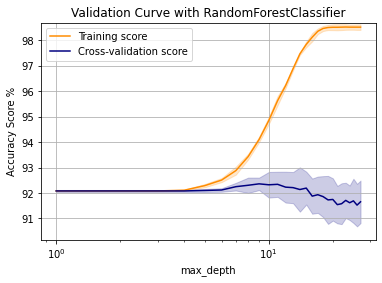

In [20]:
param_name = 'max_depth'
param_range = [int(x) for x in np.linspace(1, 27, num = 27)]

train_scoreNum, test_scoreNum = validate(param_name, param_range)
print("train_scoreNum")
print_scores(train_scoreNum, param_range)
print("test_scoreNum")
print_scores(test_scoreNum, param_range)
#param_range = param_range[:-1]
plot_param(train_scoreNum, test_scoreNum)

In [21]:
#Adding the parameter to the dictionary
random_grid['max_depth'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

##### min_samples_leaf

train_scoreNum
1 0.9852230483271376
2 0.9395446096654275
3 0.9299721189591079
4 0.9263940520446097
5 0.9239312267657992
6 0.9227695167286244
7 0.9220260223048328
test_scoreNum
1 0.9159851301115243
2 0.9232342007434944
3 0.9221189591078067
4 0.9215613382899628
5 0.9210037174721191
6 0.9211895910780669
7 0.9206319702602231


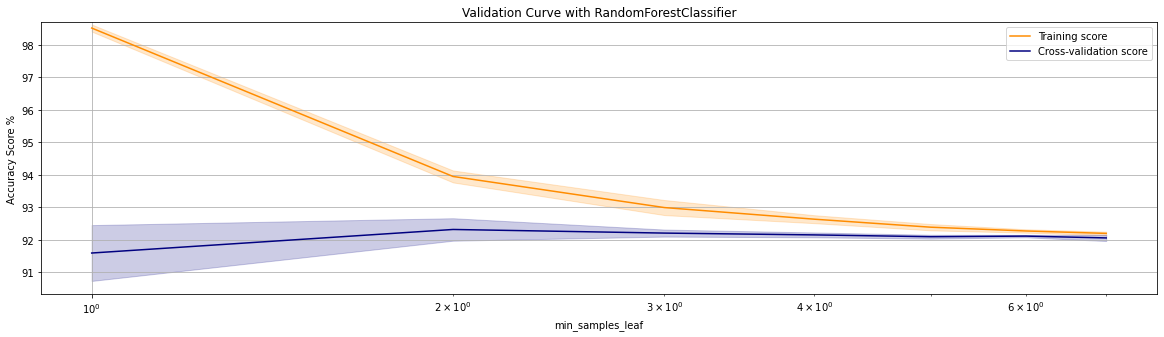

In [22]:
param_name = 'min_samples_leaf'
param_range = [1, 2, 3, 4, 5, 6, 7]

train_scoreNum, test_scoreNum = validate(param_name, param_range)
print("train_scoreNum")
print_scores(train_scoreNum, param_range)
print("test_scoreNum")
print_scores(test_scoreNum, param_range)
plot_param(train_scoreNum, test_scoreNum)

In [23]:
#Adding the parameter to the dictionary
random_grid['min_samples_leaf'] = [1, 2]

##### min_samples_split

train_scoreNum
2 0.9852695167286246
3 0.9740241635687733
4 0.9609200743494423
5 0.9526022304832713
6 0.9469330855018587
8 0.9402881040892194
10 0.9364312267657992
test_scoreNum
2 0.9152416356877323
3 0.9187732342007434
4 0.9223048327137546
5 0.9245353159851302
6 0.9226765799256504
8 0.9232342007434944
10 0.9228624535315986


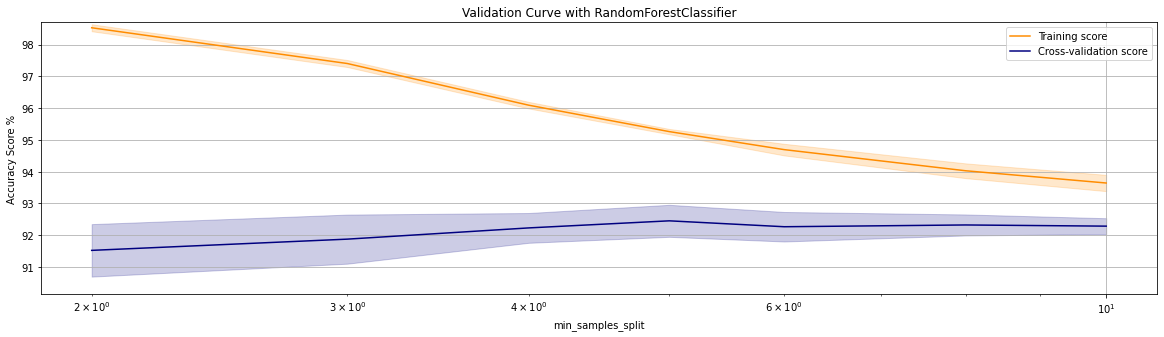

In [24]:
param_name = 'min_samples_split'
param_range = [2, 3, 4, 5, 6, 8, 10]

train_scoreNum, test_scoreNum = validate(param_name, param_range)
print("train_scoreNum")
print_scores(train_scoreNum, param_range)
print("test_scoreNum")
print_scores(test_scoreNum, param_range)
plot_param(train_scoreNum, test_scoreNum)

In [25]:
#Adding the parameter to the dictionary
random_grid['min_samples_split'] = [2, 3]

##### n_estimators

train_scoreNum
10 0.978438661710037
50 0.9847583643122677
100 0.9851765799256507
200 0.9852695167286246
250 0.9852695167286246
300 0.9852695167286246
350 0.9852695167286246
400 0.9852695167286246
450 0.9852695167286246
500 0.9852695167286246
550 0.9852695167286246
600 0.9852695167286246
650 0.9852695167286246
700 0.9852695167286246
750 0.9852695167286246
800 0.9852695167286246
850 0.9852695167286246
900 0.9852695167286246
950 0.9852695167286246
1000 0.9852695167286246
test_scoreNum
10 0.9141263940520445
50 0.9143122676579927
100 0.9171003717472119
200 0.9169144981412639
250 0.9171003717472119
300 0.9169144981412639
350 0.9169144981412639
400 0.9172862453531598
450 0.9167286245353161
500 0.9174721189591079
550 0.9169144981412639
600 0.91635687732342
650 0.9171003717472119
700 0.9171003717472119
750 0.9167286245353161
800 0.9167286245353161
850 0.9172862453531598
900 0.9161710037174722
950 0.9174721189591079
1000 0.9169144981412639


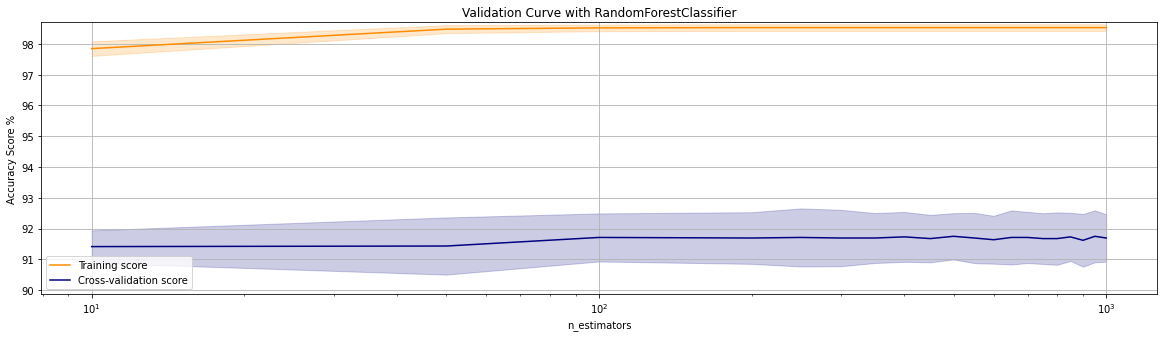

In [26]:
param_name = 'n_estimators'
param_range = [10, 50, 100, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]

train_scoreNum, test_scoreNum = validate(param_name, param_range)
print("train_scoreNum")
print_scores(train_scoreNum, param_range)
print("test_scoreNum")
print_scores(test_scoreNum, param_range)
plot_param(train_scoreNum, test_scoreNum)

In [27]:
#Adding the parameter to the dictionary
random_grid['n_estimators'] = [250]

### Setup the GridSearchCV

In [28]:
# These are the parameters to test
pprint(random_grid)

{'class_weight': [{0: 0.08, 1: 0.92}],
 'criterion': ['entropy'],
 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [2, 3],
 'n_estimators': [250]}


In [29]:
from sklearn.metrics import make_scorer, accuracy_score, recall_score
scorer = make_scorer(f1_score, pos_label=1)
clf_cv = GridSearchCV(clf, random_grid, cv=5, scoring=scorer)
clf_cv.fit(X_train, y_train)
# Predict the labels of the test set: y_pred
y_pred = clf_cv.predict(X_test)

In [30]:
print("Tuned Random Forest Parameter: {}".format(clf_cv.best_params_))
print("Tuned Random Forest Accuracy Score: {}".format(accuracy_score(y_test, y_pred)))
#print("Accuracy: {}".format(clf_cv.score(X_test, y_test)))
print("Classification report")
print(classification_report(y_test, y_pred))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

Tuned Random Forest Parameter: {'class_weight': {0: 0.08, 1: 0.92}, 'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 250}
Tuned Random Forest Accuracy Score: 0.8343239227340268
Classification report
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      1239
           1       0.25      0.55      0.35       107

    accuracy                           0.83      1346
   macro avg       0.60      0.71      0.63      1346
weighted avg       0.90      0.83      0.86      1346

Confusion Matrix
[[1064  175]
 [  48   59]]


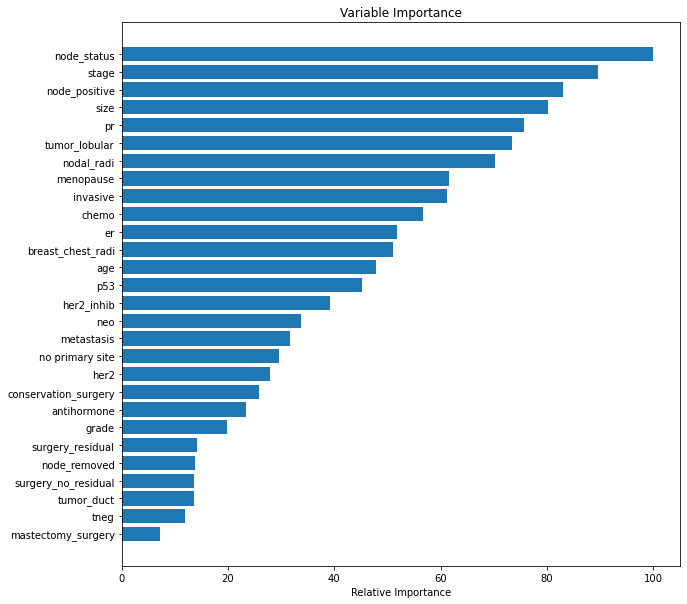

In [31]:
#Plot feature importances
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, meta_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

[[1064  175]
 [  48   59]]


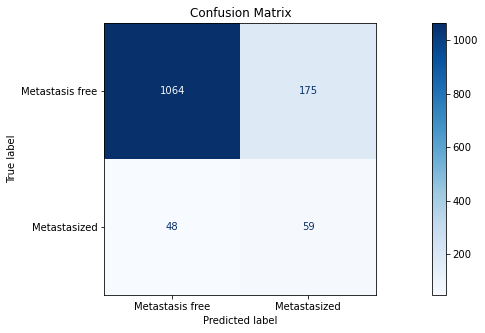

In [37]:
from sklearn.metrics import plot_confusion_matrix
np.set_printoptions(precision=1)
disp = plot_confusion_matrix(clf_cv, X_test, y_test,
                                 display_labels=['Metastasis free','Metastasized'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title("Confusion Matrix")
print(disp.confusion_matrix)
plt.show()